In [1]:
%pylab inline

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import lconv
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

sess = tf.compat.v1.InteractiveSession()
# K = tf.keras.backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer, Input, Flatten, Reshape, Dense, Conv2D, MaxPool2D

import pickle as pk
import json
# import numpy as np


from scipy import ndimage


In [3]:

def rotated_ims_rand(x):
    return np.float32([ndimage.rotate(i, (np.random.rand()-.5)*180, reshape=False, mode='nearest') for i in x])
        
class Scramble_x:
    def __init__(self,x):
        s = x.shape[1:-1]
        self.idx = np.argsort(np.random.rand(np.prod(s)))
        r,c = np.int0(self.idx/s[0]), (self.idx % s[1]) 
        self.x = np.float32([i[r,c].reshape(s+(x.shape[-1],)) for i in x])



In [4]:

# Defaults        
configs= {
    'dataset': dict(name= 'cifar100', #'mnist' ,#'mnist',cifar100, 
                    rotate=True, 
                    scramble=True,
                   ),
    'net': dict(architecture= 'lconv', # 'cnn', 'fc', 
                num_filters=32, 
                kernel_size=9, 
                L_hid= [8], #[16], 
                activation = 'relu',
                L_trainable = True,
                num_layers = 1,
               ),
}


In [5]:

dataset_name = configs['dataset']['name']

dataset = eval("tf.keras.datasets.%s.load_data()" %dataset_name) 
(x_train, y_train), (x_test,y_test) = dataset
if len(x_train.shape) == 3:
    # mnist channel is missing
    x_train = x_train[...,np.newaxis]
    
# normalize
x_train = x_train/x_train[:100].max() -.5 
# make categorical
y_train = tf.keras.utils.to_categorical(y_train)


results = {'configs':configs,}

if configs['dataset']['rotate']:
    print('Rotating images')
    x_train = rotated_ims_rand(x_train)
    
if configs['dataset']['scramble']:
    print('Scrambling images')
    scr = Scramble_x(x_train)
    x_train = scr.x
    results['scramble_idx']=scr.idx.tolist()

##### Make model #####

net = configs['net']
# arch = net['architecture']


Rotating images
Scrambling images


In [6]:
net = configs['net']

inp = Input(x_train[0].shape)

x = inp
for _ in range(net['num_layers']):
    x = tf.reshape(x, shape=(-1,np.prod(x.shape[1:-1]), x.shape[-1]))
    lay = lconv.L_Conv(num_filters= net['num_filters'], 
                          kernel_size= net['kernel_size'], 
                          L_hid = net['L_hid'], 
                          activation = net['activation'],)

    x = lay(x)
    lay.L.trainable = net['L_trainable']


x = Flatten()(x)

# x = Dense(100, activation = 'relu')(x)

out = Dense(y_train.shape[-1], activation='softmax')(x)

model = Model(inputs = [inp], outputs = [out])
model.compile(loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

model.summary()



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 1024, 3)]         0         
_________________________________________________________________
l__conv (L_Conv)             (None, 1024, 32)          132224    
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3276900   
Total params: 3,409,124
Trainable params: 3,409,124
Non-trainable params: 0
_________________________________________________________________


In [7]:
h = model.fit(x_train, y_train, validation_split=0.2, epochs=10)

# Shallow FC with parameters matching the L-conv model 

The parameters 
xs * u + u* 10

In [8]:
xs = np.prod(inp.shape[1:])
# u = int(0.5+ lay.count_params()/ xs)
u = int(.5+ model.count_params() / (model.output_shape[-1] + xs ))
u

1075

In [9]:
net = configs['net']

inp = Input(x_train[0].shape)

x = inp

x = Flatten()(inp)
# FC comparable to L-conv, but no shared weights 
x = Dense(u, activation = net['activation'])(x)

out = Dense(y_train.shape[-1], activation='softmax')(x)

model = Model(inputs = [inp], outputs = [out])
model.compile(loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

model.summary()



Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1075)              3303475   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               107600    
Total params: 3,411,075
Trainable params: 3,411,075
Non-trainable params: 0
_________________________________________________________________


In [10]:
h = model.fit(x_train, y_train, validation_split=0.2, epochs=30)

Epoch 1/30
1250/1250 [==============================] - 5s 4ms/step - loss: 4.3505 - accuracy: 0.1206 - val_loss: 4.1713 - val_accuracy: 0.1420
Epoch 2/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.9070 - accuracy: 0.1848 - val_loss: 4.2039 - val_accuracy: 0.1650
Epoch 3/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.7058 - accuracy: 0.2255 - val_loss: 4.1117 - val_accuracy: 0.1878
Epoch 4/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.5451 - accuracy: 0.2544 - val_loss: 4.8140 - val_accuracy: 0.1781
Epoch 5/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.3958 - accuracy: 0.2869 - val_loss: 4.3992 - val_accuracy: 0.1821
Epoch 6/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.2576 - accuracy: 0.3169 - val_loss: 4.5950 - val_accuracy: 0.1988
Epoch 7/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.1092 - accuracy: 0.3451 - val_loss: 4.9388 - val_accuracy:

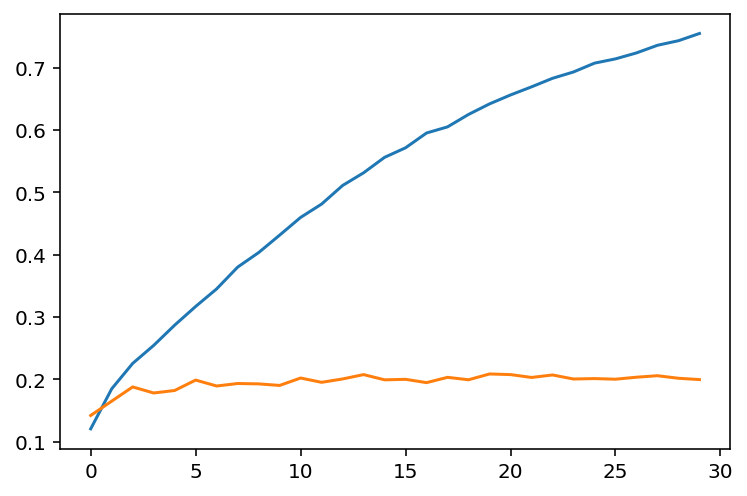

In [11]:
for k in ['accuracy', 'val_accuracy']:
    plot(h.history[k], )

In [12]:
model_name = f"FC_shallow-u{u}" 


model_name += f"-n_lay-{net['num_layers']}"
model_name += f"-act-{net['activation']}"
num_params = model.count_params() 
out_file_name = f"./results-v2/{dataset_name}/{model_name}-rotate={bool(configs['dataset']['rotate'])}-scramble={bool(configs['dataset']['scramble'])}.json"

configs['net']['architecture'] = 'fc_shallow'

results = {}
results.update({
    'num_params':num_params,
    'result':h.history,
    'configs':configs,
#     'result': {k: np.float32(v).tolist() for k,v in h.history.items()}, # bug in json or TF2
          })



# for k,v in results['result'].items():
#     print(k,type(v))

import os

# print(h.history)

dirs = os.path.split(out_file_name)[0]
os.makedirs(dirs,exist_ok=True)

print(out_file_name)

json.dump(results, open(out_file_name, 'w'))

./results-v2/cifar100/FC_shallow-u1075-n_lay-1-act-relu-rotate=False-scramble=False.json


# CNN + Max pool

In [7]:
net['num_layers'] = 1
configs


{'dataset': {'name': 'cifar100', 'rotate': True, 'scramble': True},
 'net': {'architecture': 'lconv',
  'num_filters': 32,
  'kernel_size': 9,
  'L_hid': [8],
  'activation': 'relu',
  'L_trainable': True,
  'num_layers': 1}}

In [8]:
net = configs['net']

kx = int(0.5+np.sqrt(net['kernel_size']))
ky = int(0.5+net['kernel_size']/kx)
kernel_size = (kx,ky)


inp = Input(x_train[0].shape)

x = inp
for _ in range(net['num_layers']):
    x = Conv2D(filters=net['num_filters'], 
                 kernel_size=kernel_size, 
                 activation = net['activation'])(x)

    x = MaxPool2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(x)


x = Flatten()(x)

# x = Dense(100, activation = 'relu')(x)

out = Dense(y_train.shape[-1], activation='softmax')(x)

model = Model(inputs = [inp], outputs = [out])
model.compile(loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

model.summary()



Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2691300   
Total params: 2,692,196
Trainable params: 2,692,196
Non-trainable params: 0
_________________________________________________________________


In [9]:
h = model.fit(x_train, y_train, validation_split=0.2, epochs=30)

Epoch 1/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.9167 - accuracy: 0.1236 - val_loss: 3.7271 - val_accuracy: 0.1473
Epoch 2/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.5135 - accuracy: 0.1927 - val_loss: 3.6933 - val_accuracy: 0.1582
Epoch 3/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.3421 - accuracy: 0.2239 - val_loss: 3.6467 - val_accuracy: 0.1758
Epoch 4/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.2010 - accuracy: 0.2546 - val_loss: 3.6889 - val_accuracy: 0.1663
Epoch 5/30
1250/1250 [==============================] - 5s 4ms/step - loss: 3.0754 - accuracy: 0.2845 - val_loss: 3.8055 - val_accuracy: 0.1799
Epoch 6/30
1250/1250 [==============================] - 5s 4ms/step - loss: 2.9545 - accuracy: 0.3071 - val_loss: 3.7576 - val_accuracy: 0.1786
Epoch 7/30
1250/1250 [==============================] - 5s 4ms/step - loss: 2.8452 - accuracy: 0.3301 - val_loss: 3.8578 - val_accuracy:

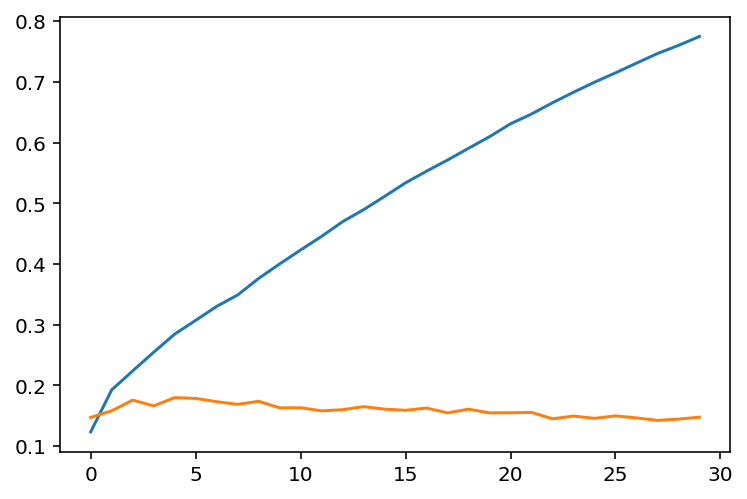

In [10]:
for k in ['accuracy', 'val_accuracy']:
    plot(h.history[k], )

In [11]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2691300   
Total params: 2,692,196
Trainable params: 2,692,196
Non-trainable params: 0
_________________________________________________________________


In [12]:
configs['net']['architecture'] = 'cnn_maxpool'

model_name = f"CNN_maxpool-nf{net['num_filters']}-ker{kernel_size}"

model_name += f"-n_lay-{net['num_layers']}"
model_name += f"-act-{net['activation']}"
num_params = model.count_params() 

out_file_name = f"./results-v2/{dataset_name}/{model_name}-rotate={bool(configs['dataset']['rotate'])}-scramble={bool(configs['dataset']['scramble'])}.json"

configs['net']['architecture'] = 'cnn_maxpool'

results = {}
results.update({
    'num_params':num_params,
    'result':h.history,
    'configs':configs,
#     'result': {k: np.float32(v).tolist() for k,v in h.history.items()}, # bug in json or TF2
          })



# for k,v in results['result'].items():
#     print(k,type(v))

import os

# print(h.history)

dirs = os.path.split(out_file_name)[0]
os.makedirs(dirs,exist_ok=True)

print(out_file_name)


json.dump(results, open(out_file_name, 'w'))

./results-v2/cifar100/CNN_maxpool-nf32-ker(3, 3)-n_lay-1-act-relu-rotate=True-scramble=True.json
